In [ ]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lazified_pdap'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from nlgcg_parameter_free import NLGCGParameterFree

# Heat Equation

## Generate Data and Define Functions

In [2]:
Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [3]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])

In [4]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        columns.append(exponentiated)
    result = np.transpose(np.array(columns), axes=(1,0))/outer_factor # shape=(len(x), len(observations))
    return result

In [5]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [6]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [7]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    outer_factor = std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        gradient = diff * exponentiated.reshape(-1,1) # shape=(len(x),Omega.shape[0])
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2))/outer_factor # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [8]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    outer_factors = [-std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2,std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0]/4]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated_normed_1 = np.exp(norms)/outer_factors[0] # (len(x),)
        exponentiated_normed_2 = np.exp(norms)/outer_factors[1] # (len(x),)
        first_part = np.repeat(np.eye(Omega.shape[0])[np.newaxis,:],len(x),axis=0)*exponentiated_normed_1.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        second_part = np.einsum('ij,ik->ijk', diff, diff)*exponentiated_normed_2.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        hessians.append(first_part+second_part)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [9]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [10]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [11]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [12]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [13]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [14]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(kappa(a.reshape(1,-1).T), axis=1)
    norm_kappa = max(vals)
elif Omega.shape[0] == 2:
    x, y = np.meshgrid(a,a)
    points = np.array(list(zip(x.flatten(), y.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_kappa = max(vals) # ||k([0.5,0.5])||
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_kappa = max(vals)
else:
    norm_kappa = 10
norm_kappa

6.264527262470839

## Experiments

In [15]:
exp = NLGCGParameterFree(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_kappa=norm_kappa,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           L=1,
           global_search_resolution=100
           )

In [26]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.nlgcg(tol=1e-12, max_radius=0.1)

INFO:root:Radii: []
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:1: choice: 0, lazy: True, support: 0, epsilon: 0.05000000000000001, objective: 2.590E+01, dropped: False
INFO:root:=====================================================
INFO:root:Radii: [0.1]
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.136E+00
INFO:root:1, 2: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:1, 3: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:1, 4: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:gap: 2.72101374272147e-11, norm grad: 1.8899295459813614e-12
INFO:root:gap: 2.72101374272147e-11, norm grad: 1.8899295459813614e-12
INFO:root:1, 5: lazy: True, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:Inequality 6.7: False
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 5.0

In [25]:
np.array(times)

array([0.        , 0.00794721, 0.02092075, 0.02841687, 0.03662348,
       0.04466438, 0.05293202, 0.06863022, 0.08158493, 0.08931375,
       0.09637165, 0.10130143, 0.10871029, 0.11532569, 0.12942433,
       0.14590955, 0.15944934, 0.1735878 , 0.19042373, 0.20458817,
       0.2109406 , 0.21613884, 0.22337556, 0.22955823, 0.78383756,
       0.79961443, 1.32571149, 1.33919549, 1.34601521, 1.35261631,
       1.3597033 , 1.86515784])

In [19]:
u.coefficients

array([ 0.99569143, -0.6175807 ,  0.71213226])

In [20]:
u.support

array([[0.28322727, 0.71433132],
       [0.49565837, 0.23548621],
       [0.73058833, 0.54790134]])

In [31]:
dropped_tot

0

# Signal Processing

## Generate Data and Define Functions

In [2]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [3]:
observations = np.arange(0,1,1/observation_resolution)

In [4]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    for t in observations:
        column = np.sin(2*np.pi*x*t).flatten()
        columns.append(column)
    result = np.transpose(np.array(columns), axes=(1,0)) # shape=(len(x), len(observations))
    return result

In [5]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [6]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [7]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    for t in observations:
        factor = 2*np.pi*t
        column = np.cos(2*np.pi*x*t) # (len(x), Omega.shape[0])
        gradient = factor * column
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2)) # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [8]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    for t in observations:
        factor = -4*np.pi**2*t**2
        column = np.sin(2*np.pi*x*t).reshape(-1,1,1) # (len(x), Omega.shape[0], Omega.shape[0])
        hessian = factor * column
        hessians.append(hessian)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [9]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [10]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [11]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [12]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [13]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [14]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(kappa(a), axis=1)
norm_kappa = max(vals)
norm_kappa

8.436705235037092

In [15]:
L = 1

## Experiments

In [16]:
exp = NLGCGParameterFree(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_kappa=norm_kappa,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           L=1,
           global_search_resolution=1000
           )

In [22]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.nlgcg(tol=1e-12, max_radius=1)

INFO:root:Radii: []
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:1: choice: 0, lazy: True, support: 0, epsilon: 0.05, objective: 5.291E+01, dropped: False
INFO:root:=====================================================
INFO:root:Radii: [1]
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:1, 2: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:1, 3: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:gap: 1.6494123025286848e-11, norm grad: 1.153599236779974e-11
INFO:root:gap: 1.6494123025286848e-11, norm grad: 1.153599236779974e-11
INFO:root:1, 4: lazy: True, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:Inequality 6.7: False
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:2: choice: 4, lazy: True, support: 2, epsilon: 0.05, objective: 1.699E+01, dropped: False
INFO:root:================================================

In [23]:
np.array(times)

array([2.38418579e-07, 1.15282536e-02, 3.64291668e-02, 4.74889278e-02,
       6.03549480e-02, 8.09674263e-02, 1.03477240e-01, 1.33018017e-01,
       1.49209261e-01, 1.58890486e-01, 1.69454336e-01, 1.81401730e-01,
       1.96549177e-01, 2.18019724e-01, 2.27967978e-01, 2.40325212e-01,
       3.42612743e-01])

In [18]:
dropped_tot

0

In [19]:
u.coefficients

array([-0.99832728,  0.69841291,  0.49833707])

In [20]:
u.support

array([[ 3.12502173],
       [ 6.9999926 ],
       [13.37905649]])

## Plots

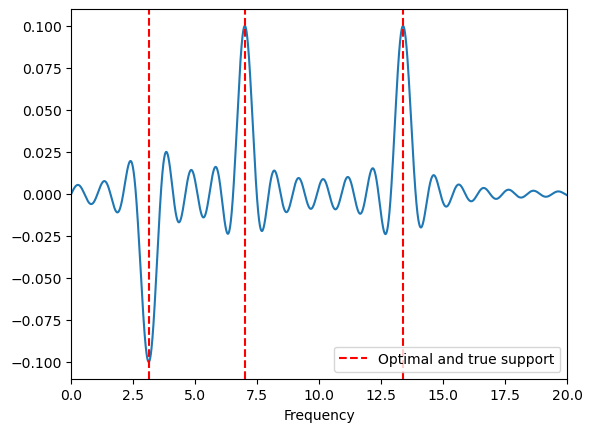

In [19]:
u_tilde = u # Newton solution
a = np.arange(Omega[0][0],Omega[0][1],0.005)
p_u = p(u_tilde)
vals = p_u(a)
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Optimal and true support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(-0.11,0.11);
plt.xlim(0, 20);
plt.legend();